In [1]:
import numpy as np
#import seaborn as sns
#import matplotlib.pyplot as plt
import csv
#import networkx as nx
import pickle
from scipy import stats

import sys
sys.path.insert(1, '../')
from utils import *

In [2]:
#dataset = 'hospital'
#dataset = 'high_school'
dataset = 'conference'
#dataset = 'workplace'

In [3]:
weighted = True

In [4]:
mu = 0.1

In [5]:
thresholds = [0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22]

In [6]:
if dataset == 'hospital':
    beta_betaT_range = [(0.6,0.8),
                        (0.2,0.8),
                        (0.4,7.5),
                        (0.3,5),
                        (0.15,5),
                        (0.3,10),
                        (0.1,10),
                        (0.06,10),
                        (0.05,15),
                        (0.05,19)]
#elif dataset == 'high_school':
    
elif dataset == 'conference':
    beta_betaT_range = [(1,12),
                        (0.9,12),
                        (0.8,12),
                        (0.7,12),
                        (0.6,12),
                        (0.5,12),
                        (0.4,12),
                        (0.3,12)]    
elif dataset == 'workplace':
    beta_betaT_range = [(0.5,6),
                        (0.5,7),
                        (0.3,6),
                        (0.4,7.3),
                        (0.2,7),
                        (0.2,7.3)]    

# Load C and obtain r and s:

C is an array of weights, I need to put it in a matrix shape to compute r and s

In [7]:
def obtain_r_s_indices(C,edgelist):
    # put C in dict:
    C_dict = {}
    n = 0
    for edge in edgelist:
        C_dict[tuple(edge)] = C[n]
        C_dict[tuple(edge[::-1])] = C[n+1]
        n += 2
    # verify:
    if list(C_dict.values()) != list(C):
        print('error')
    nb_nodes = max(np.unique(list(C_dict.keys()))) + 1
    # put C_dict in matrix:
    C_mat = np.zeros((nb_nodes,nb_nodes))
    for link in C_dict:
        C_mat[link[0],link[1]] = C_dict[link]

    # receiver index:
    r = C_mat.sum(axis=0) # somma di ogni colonna
    # spreader index:
    s = C_mat.sum(axis=1) # somma di ogni riga

    return r, s

In [8]:
with open('../data/pairwise/' + dataset + '_strength_edgelist_pairwise_sorted.pkl', 'rb') as f:
    edgelist = pickle.load(f)

Load simplicial

In [9]:
r_simplicial_list = []
s_simplicial_list = []
for (beta,betaT) in beta_betaT_range:
    filename = "../Simplicial_model/code/results/inf_treeSIR/CL_mean_weighted_%s_beta_%.3f_betaT_%.3f_mu_%.2f_init_1.csv"%(dataset,beta,betaT,mu)
    CL = load_C_mean(filename)
    filename = "../Simplicial_model/code/results/inf_treeSIR/CT_mean_weighted_%s_beta_%.3f_betaT_%.3f_mu_%.2f_init_1.csv"%(dataset,beta,betaT,mu)
    CT = load_C_mean(filename)
    C = CL + CT
    # verify:
    if 2*len(edgelist) != len(C):
        print('errore')
    r, s = obtain_r_s_indices(C,edgelist)
    r_simplicial_list.append(r)
    s_simplicial_list.append(s)
    

Load threshold

In [10]:
r_thresh_list = []
s_thresh_list = []
for th in thresholds:
    filename = "../Threshold_model/code/results/inf_treeSIR/C_mean_weighted_%s_th_%.2f_mu_%.3f.csv"%(dataset,th,mu)
  
    C = load_C_mean(filename)
    # verify:
    if 2*len(edgelist) != len(C):
        print('errore')
    r, s = obtain_r_s_indices(C,edgelist)
    r_thresh_list.append(r)
    s_thresh_list.append(s)
    

# Cosine similarity

In [11]:
sim_r = np.full((len(thresholds),len(beta_betaT_range)),0.0)
for i in range(len(thresholds)):
    for j in range(len(beta_betaT_range)):
        sim_r[i,j] = cos_sim(r_thresh_list[i],r_simplicial_list[j] )

0.7057824846985741 0.9475440130889916


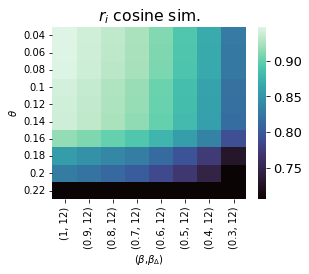

In [12]:
title='$r_i$ cosine sim.'
figname = 'figs/simplicial_thresh_cos_sim_receiver_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim_different_axes(sim_r, beta_betaT_range,thresholds,r'($\beta$,$\beta_{\Delta}$)',r'$\theta$',title,figname,save=True)

In [13]:
sim_s = np.full((len(thresholds),len(beta_betaT_range)),0.0)
for i in range(len(thresholds)):
    for j in range(len(beta_betaT_range)):
        sim_s[i,j] = cos_sim(s_thresh_list[i],s_simplicial_list[j] )

0.6598204858542457 0.8779632646416854


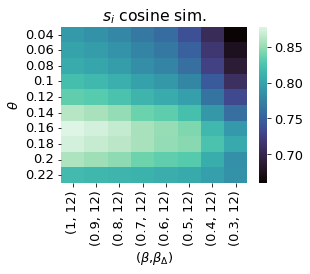

In [14]:
title='$s_i$ cosine sim.'
figname = 'figs/simplicial_thresh_cos_sim_spreader_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim_different_axes(sim_s, beta_betaT_range,thresholds,r'($\beta$,$\beta_{\Delta}$)',r'$\theta$',title,figname,save=True)

# Ranking correlation

In [15]:
corr_r = np.full((len(thresholds),len(beta_betaT_range)),0.0)
for i in range(len(thresholds)):
    for j in range(len(beta_betaT_range)):
        corr_r[i,j] = stats.spearmanr(np.array(r_thresh_list[i]),np.array(r_simplicial_list[j])).correlation

-0.5851441774288016 -0.02724787862656301


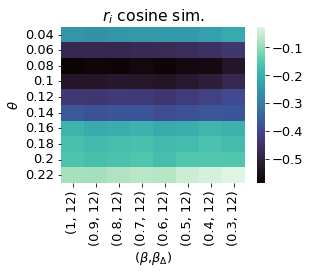

In [16]:
title='$r_i$ cosine sim.'
figname = 'figs/simplicial_thresh_rank_corr_receiver_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim_different_axes(corr_r, beta_betaT_range,thresholds,r'($\beta$,$\beta_{\Delta}$)',r'$\theta$',title,figname,save=True)

In [17]:
corr_s = np.full((len(thresholds),len(beta_betaT_range)),0.0)
for i in range(len(thresholds)):
    for j in range(len(beta_betaT_range)):
        corr_s[i,j] = stats.spearmanr(np.array(s_thresh_list[i]),np.array(s_simplicial_list[j])).correlation

0.5434103363987458 0.7555186237839486


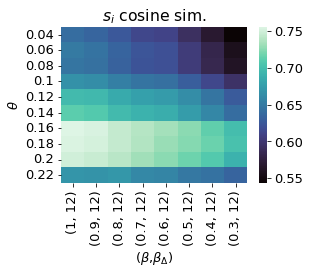

In [18]:
title='$s_i$ cosine sim.'
figname = 'figs/simplicial_thresh_rank_corr_spreader_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim_different_axes(corr_s, beta_betaT_range,thresholds,r'($\beta$,$\beta_{\Delta}$)',r'$\theta$',title,figname,save=True)

In [19]:
figname

'figs/simplicial_thresh_rank_corr_spreader_conference_mu_0.10.pdf'